## 학습 알고리즘 구현
키워드 -> 손실함수, 미니배치, 기울기, 경사 하강법

<신경망 학습의 절차>   

1단계: 미니배치
- 훈련 데이터 중 일부를 무작위로 가져오고 이를 **미니배치**라 한다.
- 우리의 목표는 이 미니배치의 손실 함수값을 줄이는 것이 목표이다.

2단계: 기울기 산출
- 각 매개변수의 손실함수의 값을 가장 작게하는 방향을 제시하는 **가중치 매개변수의 기울기**를 구한다.
- 기울기와 가중치 매개변수가 갱신(이동)해야할 방향은 반대이다!

3단계: 매개변수 갱신
- 가중치 매개변수를 아주 조금 갱신.

4단계: 1~3단계 반복


위 과정은 데이터를 미니배치로 무작위 선정하기 때문에 **Stochastic Gradient Descent(SGD), 즉 확률적 경사 하강법**이라 부른다.


In [15]:
import sys, os
import numpy as np
sys.path.append(os.path.join(os.getcwd(), 'deep-learning-from-scratch/'))

from common.functions import *
from common.gradient import numerical_gradient

In [16]:
class TwoLayerNet:
    # 입력층, 은닉층, 출력층 의 뉴런수를 생성자에서 받아 params값 초기화에 사용
    def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
        # 1. 가중치 초기화 => 무엇으로 초기화하냐가 매우 중요, 추후 살펴볼 예정
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
    
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}
        
        batch_num = x.shape[0]
        
        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        # backward
        dy = (y - t) / batch_num
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)
        
        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads


In [17]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [18]:
x = np.random.rand(100, 784) # 더미 입력 데이터
t = np.random.rand(100, 10)  # 더미 정답 레이블 

In [21]:
from dataset.mnist import load_mnist

In [22]:
# 데이터 읽기
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []

# 하이퍼파라미터
iters_num = 10000  # Gradient Descent 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기 -> 60,000개의 데이터 중 100개를 임의로 뽑아쓸거다
learning_rate = 0.1

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)


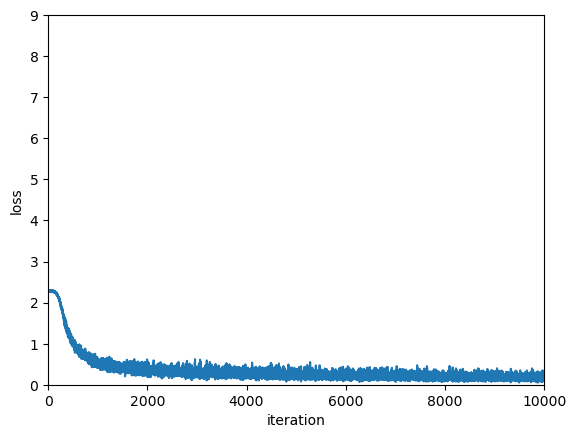

In [23]:
# 그래프 그리기
import matplotlib.pyplot as plt

x = np.arange(len(train_loss_list))
plt.plot(x, train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.ylim(0, 9)
plt.xlim(0, 10000)
plt.show()


- 위 그래프를 보면 경사하강 횟수가 진행됨에 따라 loss값이 줄어들고 있다.
- 하지만 저 그래프는 batch만을 기준으로 한 것이다.
- 따라서 위 그래프는 다른 데이터를 제대로 인지하는, 즉 범용 능력을 평가용도론 사용 불가하다.

하단 코드는 학습 도중 정기적으로 훈련셋, 시험셋을 대상으로 정확도를 기록한다.

In [25]:
network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

# 하이퍼파라미터
iters_num = 10000  # 반복 횟수를 적절히 설정한다.
train_size = x_train.shape[0]
batch_size = 100   # 미니배치 크기
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

train acc, test acc | 0.10218333333333333, 0.101
train acc, test acc | 0.7972, 0.8015
train acc, test acc | 0.87785, 0.8805
train acc, test acc | 0.8982, 0.9012
train acc, test acc | 0.90895, 0.9107
train acc, test acc | 0.91535, 0.916
train acc, test acc | 0.9198166666666666, 0.9213
train acc, test acc | 0.9239666666666667, 0.925
train acc, test acc | 0.9269666666666667, 0.9288
train acc, test acc | 0.93035, 0.9331
train acc, test acc | 0.9340166666666667, 0.9359
train acc, test acc | 0.9363833333333333, 0.9365
train acc, test acc | 0.9385166666666667, 0.9382
train acc, test acc | 0.9409, 0.94
train acc, test acc | 0.943, 0.9415
train acc, test acc | 0.94445, 0.9429
train acc, test acc | 0.9462, 0.9455


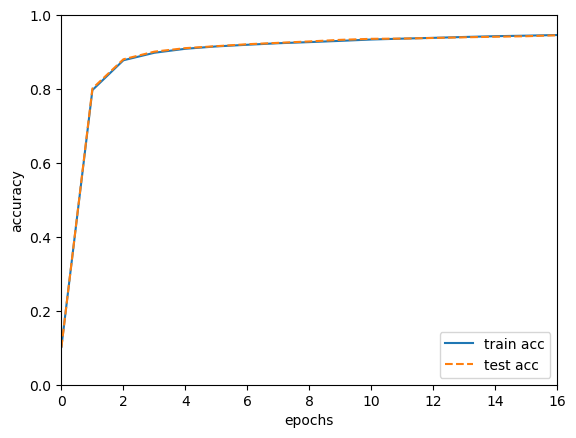

In [26]:
# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    # 기울기 계산
    #grad = network.numerical_gradient(x_batch, t_batch)
    grad = network.gradient(x_batch, t_batch)
    
    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# 그래프 그리기
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label='train acc')
plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.xlim(0, 16)
plt.legend(loc='lower right')
plt.show()


- 1epoch마다 정확도를 기록한다.
- 훈련셋, 시험셋 다 정확도가 에포크가 진행됨에 따라 상승한다 => 과적합 X